In [1]:
import numpy as np
import control as ct
from planar_quad import PlanarQuad
import matplotlib.pyplot as plt

In [52]:
mass = 0.6
length = 0.2
inertia = 0.15
gravity = 9.81
dt = 0.01
quad = PlanarQuad(dt, mass, length, inertia, gravity)
A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))
C = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
# Start with a diagonal weighting
Q_ctrl = np.array([[1e+2, 0., 0., 0., 0., 0.],
                           [0., 1e+2, 0., 0., 0., 0.],
                           [0., 0., 1e+2, 0., 0., 0.],
                           [0., 0., 0., 1e+2, 0., 0.],
                           [0., 0., 0., 0., 1e+2, 0.],
                           [0., 0., 0., 0., 0., 1e+2]])

R_ctrl = np.array([[1e-03, 0.],
                           [0., 1e-03]])

K, _, _ = ct.dlqr(A, B, Q_ctrl, R_ctrl)  

Q_est = np.eye(6)
R_est = np.eye(2)

L, _, _ = ct.dlqe(A, np.eye(6), C, Q_est, R_est)  

A_delta = np.block([[A-B@K, B@K, np.zeros((6,6)), np.zeros((6,6))], 
                   [np.zeros((6,6)), A-L@C@A, np.zeros((6,6)), np.zeros((6,6))],
                   [np.zeros((6,6)), np.zeros((6,6)), (np.eye(6) - L@C)@A - B@K, np.zeros((6,6))],
                   [np.zeros((6,6)), np.zeros((6,6)), np.zeros((6,6)), np.eye((6))]])

B_delta = np.block([[np.zeros((6,2))],
                    [-L@np.eye(2)],
                    [L@np.eye(2)],
                    [np.zeros((6,2))]
                    ])
W_delta = np.block([[np.eye(6), np.zeros((6,2))],
                    [(np.eye(6) - L@C), -L],
                    [np.zeros((6,6)),np.zeros((6,2))],
                    [np.zeros((6,6)),np.zeros((6,2))]])

C_tilde = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
C_delta = np.block([[C_tilde,np.zeros((2,6)),np.zeros((2,6)), np.zeros((2,6))],
                    [np.zeros((2,6)),np.zeros((2,6)),C_tilde, np.zeros((2,6))],
                   [np.zeros((6,6)),np.zeros((6,6)),np.zeros((6,6)), np.eye(6)]])

M = np.block([np.zeros((2,6)),np.zeros((2,6)),-C, np.zeros((2,6))])
Q_delta_est = np.eye(24)
R_delta_est = np.eye(10)
Lo, _, _ = ct.dlqe(A_delta, np.eye(24), C_delta, Q_delta_est, R_delta_est) 

Text(0.5, 0, 'Time [s]')

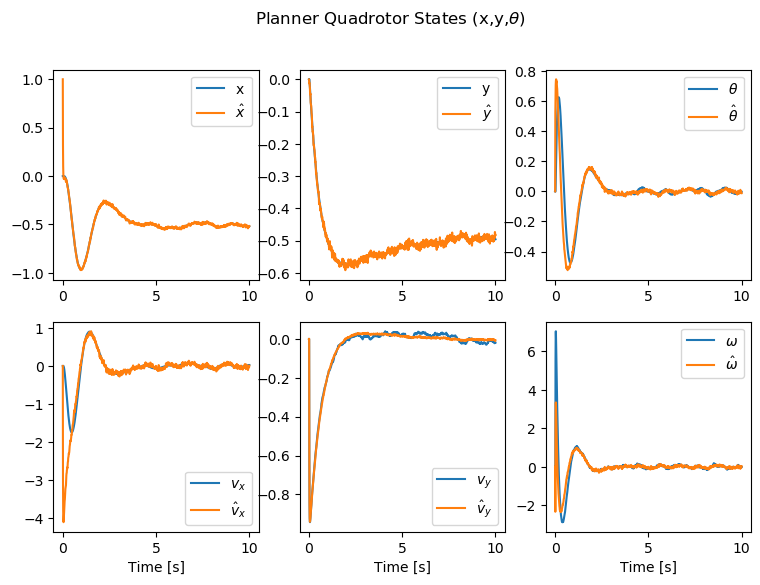

In [83]:
T =1000
t = np.zeros([T+1,])
x0 = np.array([0, 0., 0., 0., 0, 0.])
x0_est = np.array([1, 0., 0., 0., 0, 0.])

eta = np.empty([24, T+1])
eta_est = np.empty([24, T+1])
epsilon = np.empty([2, T])

eta[:,0] = np.block([x0, np.zeros(6), np.zeros(6), np.array([1,-1,0,0,0,0])])
eta_est[:,0] = np.block([x0_est, np.zeros(6), np.zeros(6), np.array([10.0,0.1,0,0,0,0])])
epsilon[:,0] = np.zeros(2)
a = np.array([0.5, 0.5])

for i in range(T):
    w = 0.001*np.random.randn(6,1)
    v = 0.001*np.random.randn(2,1)
    w_tilde = np.block([[w],[v]]).reshape((8,))
    epsilon[:,i] = M@eta[:,i] + a
    eta[:,i+1] = A_delta@eta[:,i] + B_delta@a + W_delta@w_tilde
    v = 0.01*np.random.randn(10)
    y = C_delta@eta[:,i+1] + v
    eta_est[:,i+1] = A_delta@eta_est[:,i] + B_delta@a + Lo@(y - C_delta@A_delta@eta_est[:,i])
    t[i+1] = t[i] + 0.01
state = eta[:6,:] 
state_est = eta_est[:6,:] 

plt.figure(figsize=[9,6])
plt.suptitle('Planner Quadrotor States (x,y,$\\theta$)')
plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_est[0,:])
plt.legend(['x','$\hat{x}$','$\hat{x}^0$'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_est[2,:])
plt.legend(['y', '$\hat{y}$', '$\hat{y}^0$'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_est[4,:])
plt.legend(['$\\theta$','$\hat{\\theta}$', '$\hat{\\theta}^0$'])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_est[1,:])
plt.legend(['$v_x$','$\hat{v}_x$', '$\hat{v}_x^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_est[3,:])
plt.legend(['$v_y$','$\hat{v}_y$', '$\hat{v}_y^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_est[5,:])
plt.legend(['$\omega$','$\hat{\omega}$', '$\hat{\omega}^0$'])
plt.xlabel('Time [s]')

In [41]:
import cvxpy as cp
from scipy.linalg import sqrtm

def solve_lmi(A, B, C, W, Bo, Lo, eta_est, M_xi, n_states=6, verbose=True):
    rho = cp.Constant(0.005) 
    d_max = cp.Constant(1)


    n = n_states*4 # Augmented state dim
    m = B.shape[1] # Attack vector dim
    q = W.shape[1] # Augmented dis dim
    p = C.shape[0] # Augmented meas dim
    
    G1 = cp.Variable((n,n))
    G2 = cp.Variable((n,n))
    G12 = cp.Variable((n,n))
    
    Q = cp.Variable((n_states,n_states))
   
    Y = cp.Variable((m,n))
    Z = cp.Variable((n,n))
    
    gamma = cp.Variable()
    sigma = cp.Variable()


    Q_curly = 2*np.eye(n_states)
    T = np.block([np.eye(n_states), np.zeros((n_states,n_states)),np.zeros((n_states,n_states)),-np.eye(n_states)])
    T_curly = np.block([T, T])
    
    G = cp.Variable((n_states, 2*n))#cp.bmat([[G1 , np.zeros((n,n))],[G12, G2]])
    G_tilde = T_curly.T@G + G.T@T_curly - G.T@Q@G
    print(G_tilde.shape)
    #spade_1 = cp.bmat([[Z + Bo@Y + Lo@C@(G12+G1), Lo@C@G2],[(A - Lo@C)@(G12+G1) - Z + (B - Bo)@Y, (A - Lo@C)@G2]])

    spade_1 = cp.bmat([[Z + Bo@Y + Lo@C, Lo@C],[(A - Lo@C) - Z + (B - Bo)@Y, (A - Lo@C)]])
    spade_2 = cp.bmat([[np.zeros((n,q)), Lo],[W, -Lo]])
    block_eq1 = cp.bmat([
        [G_tilde - rho*G_tilde, np.zeros((2*n,p+q)),(T_curly@spade_1).T, (sqrtm(Q_curly)@T_curly).T],
        [np.zeros((p+q,2*n)), rho*np.eye(p+q)/d_max, (T_curly@spade_2).T, np.zeros((p+q,n_states))],
        [T_curly@spade_1, T_curly@spade_2, Q,  np.zeros((n_states,n_states))],
        [sqrtm(Q_curly)@T_curly, np.zeros((n_states,p+q)),np.zeros((n_states,n_states)), gamma*np.eye(n_states)]])
    
   
    block_eq2 = cp.bmat([
        [np.eye(1) - sigma*np.eye(1), eta_est.T],
        [eta_est,T.T@Q@T]])
    
    block_eq3 = cp.bmat([
        [sigma*M_xi, np.eye(n)],
        [np.eye(n),T.T@Q@T]])
    

    const = [block_eq1 >> 0]#, block_eq2>>0, block_eq3>>0]
    prob = cp.Problem(cp.Minimize(gamma), constraints = const)
    try:
        prob.solve(solver = cp.MOSEK, eps=1e-6, verbose=verbose)
        cost = gamma.value
        return {
            'cost': cost,
            'Y': np.round(np.array(Y.value), 6),
            'Z': np.round(np.array(Z.value), 6),
            # 'A': np.round(np.array(Z.value@ np.linalg.inv(G1.value)), 6),
            # 'F': np.round(np.array(Y.value@np.linalg.inv(G1.value)), 6),
            'Q': np.round(np.array(Q.value), 6),
            'gamma': gamma.value
        }
    except Exception as e:
        print(e)
        cost = -1    
        return None   
res = solve_lmi(A_delta, B_delta, C_delta, W_delta, B_delta, Lo, np.zeros((24,1)), np.eye(24), n_states=6)

(48, 48)
                                     CVXPY                                     
                                     v1.5.0                                    
(CVXPY) Jun 11 03:48:45 PM: Your problem has 949 variables, 6084 constraints, and 0 parameters.
(CVXPY) Jun 11 03:48:45 PM: It is compliant with the following grammars: 
(CVXPY) Jun 11 03:48:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 11 03:48:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 11 03:48:45 PM: Your problem is compiled with the CPP canonicalization backend.
Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
Vstack(Hstack([[1.00 0.00 ... 0.00 0.00]
 [0.00 1.00 ... 0.00 0.00]
 ...
 [-0.00 -0.00 ... -1.00 -0.00]
 [-0.00 -0.00 ... -0.00 -1.00]] @ var2772 + var2772.T @ [[1.00 0.00 ... -0.00 -0.00]
 [0.00 1.00 ... -0.00 -0.00]
 .

In [2]:
mass = 0.6
length = 0.2
inertia = 0.15
gravity = 9.81
dt = 0.01
quad = PlanarQuad(dt, mass, length, inertia, gravity)
A, B = quad.linear_dyn(np.zeros((6, )), np.array([quad.m * quad.g / 2, quad.m * quad.g / 2]))
C = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
# Start with a diagonal weighting
Q_ctrl = np.array([[1e+2, 0., 0., 0., 0., 0.],
                           [0., 1e+2, 0., 0., 0., 0.],
                           [0., 0., 1e+2, 0., 0., 0.],
                           [0., 0., 0., 1e+2, 0., 0.],
                           [0., 0., 0., 0., 1e+2, 0.],
                           [0., 0., 0., 0., 0., 1e+2]])

R_ctrl = np.array([[1e-03, 0.],
                           [0., 1e-03]])

K, _, _ = ct.dlqr(A, B, Q_ctrl, R_ctrl)  

Q_est = np.eye(6)
R_est = np.eye(2)

L, _, _ = ct.dlqe(A, np.eye(6), C, Q_est, R_est)  

A_delta = np.block([[A-B@K, B@K, np.zeros((6,6))], 
                   [np.zeros((6,6)), A-L@C@A, np.zeros((6,6))],
                   [np.zeros((6,6)), np.zeros((6,6)), (np.eye(6) - L@C)@A - B@K]])

B_delta = np.block([[np.zeros((6,2))],
                    [-L@np.eye(2)],
                    [L@np.eye(2)]
                    ])
W_delta = np.block([[np.eye(6), np.zeros((6,2))],
                    [(np.eye(6) - L@C), -L],
                    [np.zeros((6,6)),np.zeros((6,2))]])

C_tilde = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
C_delta = np.block([[C_tilde,np.zeros((2,6)),np.zeros((2,6))],
                    [np.zeros((2,6)),np.zeros((2,6)),C_tilde]])
M = np.block([np.zeros((2,6)),np.zeros((2,6)),-C])
Q_delta_est = np.eye(18)
R_delta_est = np.eye(4)
Lo, _, _ = ct.dlqe(A_delta, np.eye(18), C_delta, Q_delta_est, R_delta_est) 

Text(0.5, 0, 'Time [s]')

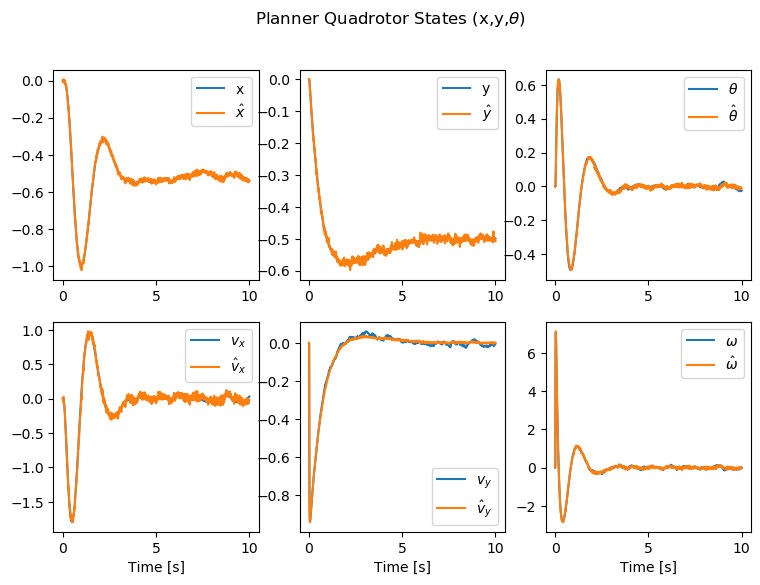

In [3]:
T =1000
t = np.zeros([T+1,])
x0 = np.array([0, 0., 0., 0., 0, 0.])
x0_est = np.array([0.0, 0., 0., 0., 0, 0.])

eta = np.empty([18, T+1])
eta_est = np.empty([18, T+1])
epsilon = np.empty([2, T])

eta[:,0] = np.block([x0, np.zeros(6), np.zeros(6)])
eta_est[:,0] = np.block([x0_est, np.zeros(6), np.zeros(6)])
epsilon[:,0] = np.zeros(2)
a = np.array([0.5, 0.5])

for i in range(T):
    w = 0.001*np.random.randn(6,1)
    v = 0.001*np.random.randn(2,1)
    w_tilde = np.block([[w],[v]]).reshape((8,))
    epsilon[:,i] = M@eta[:,i] + a
    eta[:,i+1] = A_delta@eta[:,i] + B_delta@a + W_delta@w_tilde
    v = 0.01*np.random.randn(4)
    y = C_delta@eta[:,i+1] + v
    eta_est[:,i+1] = A_delta@eta_est[:,i] + B_delta@a + Lo@(y - C_delta@A_delta@eta_est[:,i])
    t[i+1] = t[i] + 0.01
state = eta[:6,:] 
state_est = eta_est[:6,:] 

plt.figure(figsize=[9,6])
plt.suptitle('Planner Quadrotor States (x,y,$\\theta$)')
plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_est[0,:])
plt.legend(['x','$\hat{x}$','$\hat{x}^0$'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_est[2,:])
plt.legend(['y', '$\hat{y}$', '$\hat{y}^0$'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_est[4,:])
plt.legend(['$\\theta$','$\hat{\\theta}$', '$\hat{\\theta}^0$'])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_est[1,:])
plt.legend(['$v_x$','$\hat{v}_x$', '$\hat{v}_x^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_est[3,:])
plt.legend(['$v_y$','$\hat{v}_y$', '$\hat{v}_y^0$'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_est[5,:])
plt.legend(['$\omega$','$\hat{\omega}$', '$\hat{\omega}^0$'])
plt.xlabel('Time [s]')

In [8]:
import cvxpy as cp
from scipy.linalg import sqrtm

def solve_lmi(A, B, C, W, Bo, Lo, eta_est, eta_star, M_xi, n_states=6, verbosity=0):
    rho = cp.Constant(0.05) 
    d_max = cp.Constant(1)


    n = n_states*3 # Augmented state dim
    m = B.shape[1] # Attack vector dim
    q = W.shape[1] # Augmented dis dim
    p = C.shape[0] # Augmented meas dim
    
    G1 = cp.Variable((n,n))
    G2 = cp.Variable((n,n))
    G12 = cp.Variable((n,n))

    Q1 = cp.Variable((n,n), PSD=True)
    Q2 = cp.Variable((n,n), PSD=True)
    

    Y = cp.Variable((m,n))
    Z = cp.Variable((n,n))
    
    gamma = cp.Variable()
    sigma = cp.Variable()
    


    Q_curly = 1e2*np.eye(2*n)
    Q_ = cp.Variable((2*n,2*n))
    Q = cp.bmat([[Q1 , np.zeros((n,n))],[np.zeros((n,n)), Q2]])
    G = cp.bmat([[G1 , np.zeros((n,n))],[G12, G2]])
    G_tilde = cp.bmat([[G1 + G1.T - Q1, G12.T],[G12, G2 + G2.T - Q2]])
    
    #spade_1 = cp.bmat([[Z + Bo@Y + Lo@C@(G12+G1), Lo@C@G2],[(A - Lo@C)@(G12+G1) - Z + (B - Bo)@Y, (A - Lo@C)@G2]])

    spade_1 = cp.bmat([[A@G1 + Bo@Y, Lo@C@A@(G12+G2)],[np.zeros((n,n)), (A - Lo@C)@G2]])
    
    spade_2 = cp.bmat([[np.zeros((n,q)), -Lo],[W, -Lo]])
    block_eq1 = cp.bmat([
        [G_tilde-rho*G_tilde, np.zeros((2*n,p+q)),spade_1.T, (sqrtm(Q_curly)@G).T],
        [np.zeros((p+q,2*n)), (rho/d_max)*np.eye(p+q), spade_2.T, np.zeros((p+q,2*n))],
        [spade_1, spade_2, Q,  np.zeros((2*n,2*n))],
        [sqrtm(Q_curly)@G, np.zeros((2*n,p+q)),np.zeros((2*n,2*n)), gamma*np.eye(2*n)]])
    
    
    block_eq2 = cp.bmat([
        [np.eye(1) - sigma*np.eye(1), (eta_est-eta_star).T],
        [eta_est-eta_star,Q1]])
    
    block_eq3 = cp.bmat([
        [sigma*M_xi, np.eye(n)],
        [np.eye(n),Q2]])
    
    const = [block_eq1 >> 0]#, block_eq2>>0, block_eq3>>0]
    prob = cp.Problem(cp.Minimize(gamma), constraints = const)
    try:
        prob.solve(solver = cp.MOSEK, verbose=True)
        cost = gamma.value
    except Exception as e:
        print(e)
        cost = -1       
    return {
        'cost': cost,
        'A': np.round(np.array(Z.value@ np.linalg.inv(G1.value)), 3),
        'F': np.round(np.array(Y.value @ np.linalg.inv(G1.value)), 3),
        'Q1': np.round(np.array(Q1.value), 3),
        'Q2': np.round(np.array(Q2.value), 3),
        'gamma': gamma
    }

eta_star = np.block([np.array([[0.0],[0.0],[0.0],[0],[0],[0]]),np.array([[0.0],[0.0],[0.0],[0],[0],[0]]),np.zeros((6,1))])
res = solve_lmi(A_delta, B_delta, C_delta, W_delta, B_delta, Lo, np.zeros((18,1)), np.zeros((18,1)),  np.eye(18), n_states=6)

                                     CVXPY                                     
                                     v1.5.0                                    
(CVXPY) Jun 25 02:13:15 PM: Your problem has 1657 variables, 14400 constraints, and 0 parameters.
(CVXPY) Jun 25 02:13:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 25 02:13:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 25 02:13:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 25 02:13:15 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 25 02:13:15 PM: Compiling problem (target solver=MOSEK

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional